In [3]:
import numpy as np
import pickle
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt
import os

In [2]:
# Rutas
ruta_datos = "../data/"    # defino ruta a los datos 
nombre_datos = 'data_gestos_puntuales_fs200_DB3.pickle'

# Conformación de datasets
input_sequence_length = 650     # largo de las secuencias en muestras
stride = 5      # stride de las secuencias
sup_gesto_secuencia = 1     # superposición gesto-secuencia

In [4]:
# Cargo los datos
os.chdir(ruta_datos) # me situo en el directorio
file = open(nombre_datos, 'rb') # abro el archico
MyoArm_data = pickle.load(file) # guardo los datos en un data y cierro el archivo
file.close()

In [5]:
# Extraigo los datos del dataframe
data = MyoArm_data['data']
label = MyoArm_data['label']
subject = MyoArm_data['subject']

nOfSubjects = np.max(subject)   # calculo la cantidad de sujetos

In [6]:
# TODO no hardcodear el mapeo
# Creo un diccionario de mapeo para los valores de etiqueta
mapeo = {0: 0, 5: 1, 6: 2, 7: 3, 9: 4, 10: 5, 13: 6, 14: 7, 22: 8, 26: 9, 31: 10}

# Hago el reemplazo de las etiquetas
label = np.vectorize(mapeo.get)(label)

In [7]:
def aplicar_imputer(data, label):
  # calculo desviacion estandar sobre los datos de reposo
  ind_reposo = np.where(label==0)[0]

  std_reposo = np.nanstd(data[ind_reposo], axis=0)
  mean_reposo = np.nanmean(data[ind_reposo], axis=0)

  # relleno manualmente los NaN en cada columna con los valores de relleno
  for i in range(data.shape[1]):
      nan_mask = np.isnan(data[:, i])  # máscara de los NaN en la columna i
      data[nan_mask, i] = std_reposo[i]*np.random.normal() + mean_reposo[i]  # reemplazo los NaN por el valor de relleno correspondiente

  return data

data = aplicar_imputer(data, label)

# Para termianr, chequeo si hay alguna etiqueta nan
nan_indices = np.isnan(data)
np.where(nan_indices==True)

(array([], dtype=int64), array([], dtype=int64))

In [8]:
# hago una lista de dataframes, donde cada elemento tiene los datos asociados a los distintos sujetos 
list_data_x_sujeto = []
list_label_x_sujeto = []

for i in range(1, nOfSubjects+1):
  ind_sujeto_act = np.where(subject==i)[0]
  list_data_x_sujeto.append(data[ind_sujeto_act])
  list_label_x_sujeto.append(label[ind_sujeto_act])

In [11]:
# calculo cantidad de repeticiones de cada gesto
flancos = np.diff(label)  # con estos flancos puedo dividir las repeticiones
rep_starts_ind = np.where(flancos>0)[0]
rep_ends_ind = np.where(flancos<0)[0]

# identifico y numero cada repetición
etiqueta_repeticion = []  # identificacion de cada repeticion
indices_repeticion = []   # que muestras conforman cada repeticion

for i in range(1, 11):
  rep_start_ind = np.where(flancos==i)[0]
  rep_end_ind = np.where(flancos==-i)[0]
  for j in range(len(rep_start_ind)):
    indices_repeticion.append(np.arange(rep_start_ind[j]+1, rep_end_ind[j]+1))
    etiqueta_repeticion.append(i)

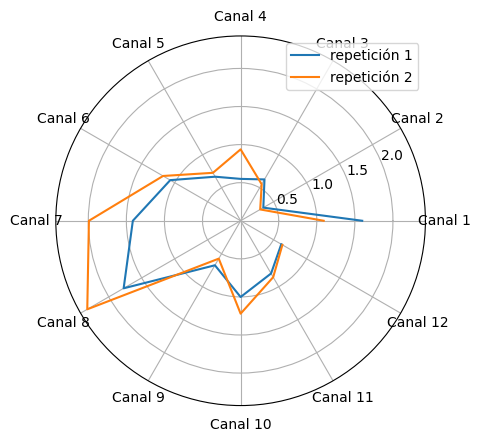

In [12]:
# calculo std de repetición

i = 0
sig = data[(rep_starts_ind[i]+1): (rep_ends_ind[i]+1)]

std_x_canal = np.std(sig, axis=0)

i = 1
sig1 = data[(rep_starts_ind[i]+1): (rep_ends_ind[i]+1)]

std_x_canal1 = np.std(sig1, axis=0)


# Crear un gráfico polar
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

# Ángulos para cada canal
theta = np.linspace(0, 2*np.pi, len(std_x_canal), endpoint=False)

# Graficar los datos
ax.plot(theta, std_x_canal, label = 'repetición 1')
# Graficar los datos
ax.plot(theta, std_x_canal1, label = 'repetición 2')

# Especificar la cantidad de ticks manualmente para que coincida con la cantidad de etiquetas.
ax.set_xticks(theta)

# Definir las etiquetas para los ticks.
labels = ['Canal 1', 'Canal 2', 'Canal 3', 'Canal 4', 'Canal 5', 'Canal 6', 'Canal 7', 'Canal 8', 'Canal 9', 'Canal 10', 'Canal 11', 'Canal 12']

# Establecer las etiquetas de los ticks.
ax.set_xticklabels(labels)

# Añadir una leyenda
ax.legend(loc='upper right')

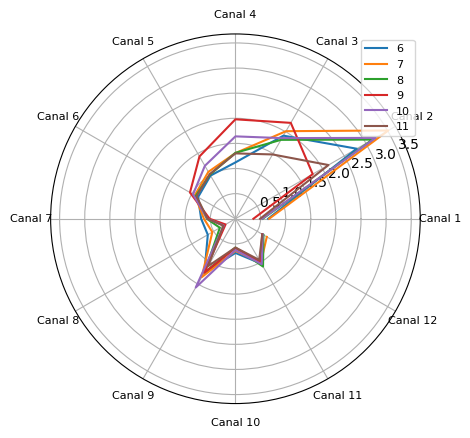

In [13]:
# Crear un gráfico polar
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

for i in range(6, 12):
  sig = data[(rep_starts_ind[i]+1): (rep_ends_ind[i]+1)]
  std_x_canal = np.std(sig, axis=0)

  # Ángulos para cada canal
  theta = np.linspace(0, 2*np.pi, len(std_x_canal), endpoint=False) # va a ser el mismo en todas las iteraciones

  # Graficar los datos
  ax.plot(theta, std_x_canal, label = str(i))

# Especificar la cantidad de ticks manualmente para que coincida con la cantidad de etiquetas.
ax.set_xticks(theta)

# Definir las etiquetas para los ticks.
labels = ['Canal 1', 'Canal 2', 'Canal 3', 'Canal 4', 'Canal 5', 'Canal 6', 'Canal 7', 'Canal 8', 'Canal 9', 'Canal 10', 'Canal 11', 'Canal 12']

# Establecer las etiquetas de los ticks.
ax.set_xticklabels(labels, fontsize=8)

# Añadir una leyenda
ax.legend(loc='upper right', fontsize=8)

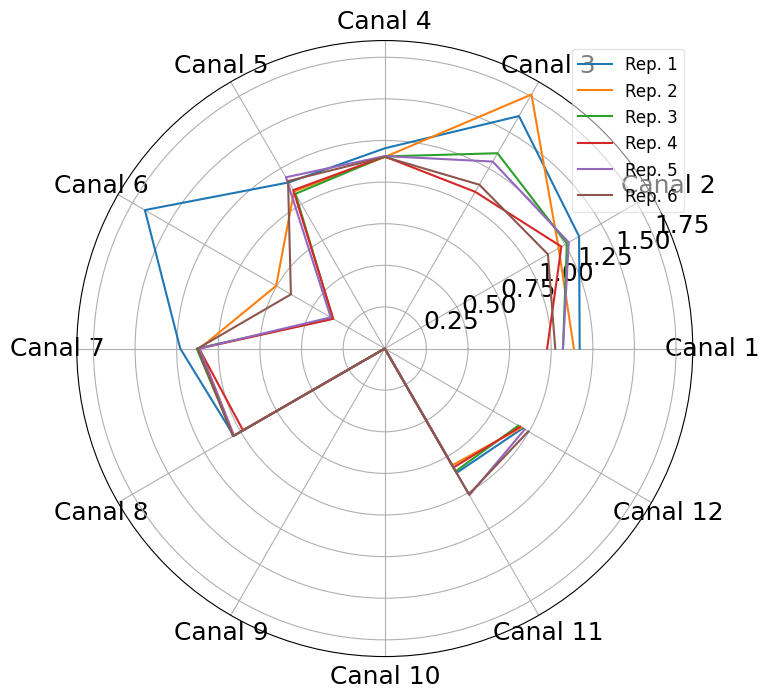

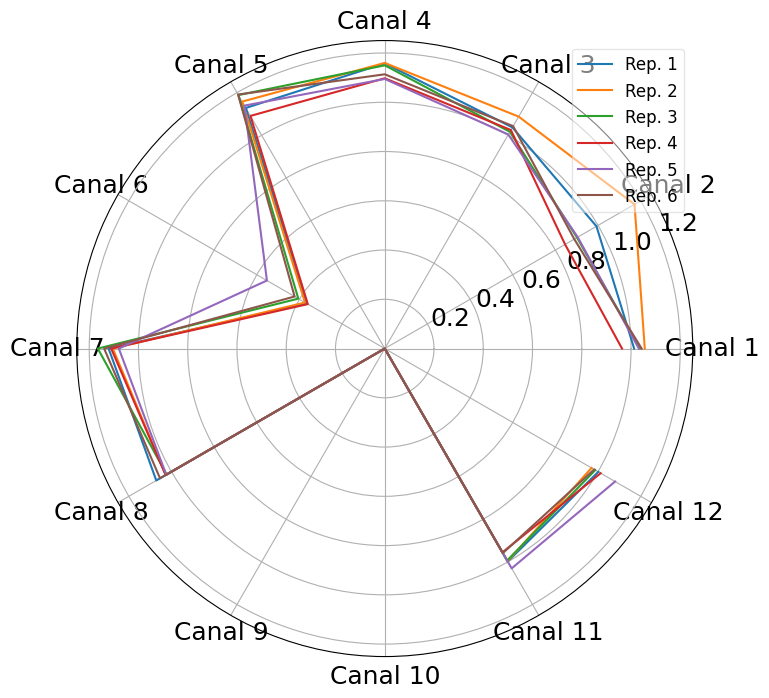

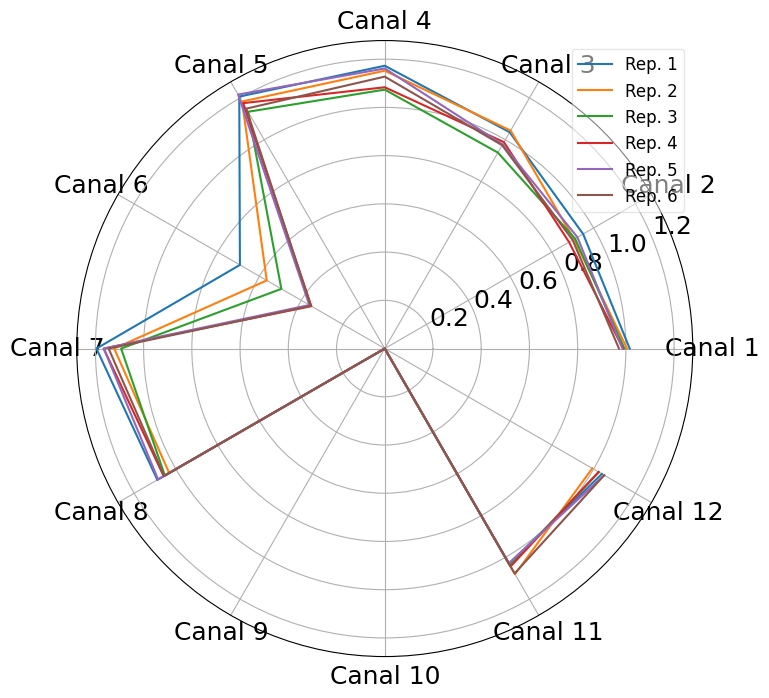

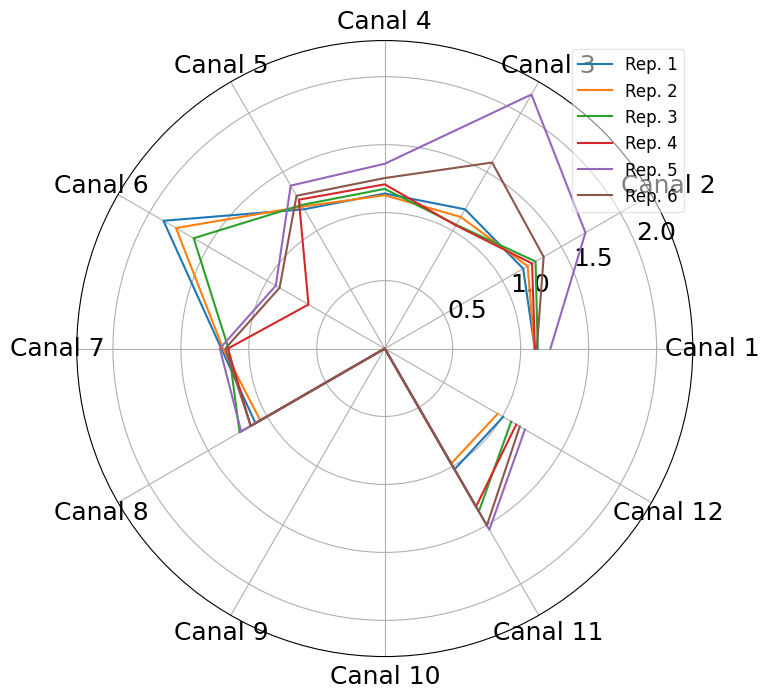

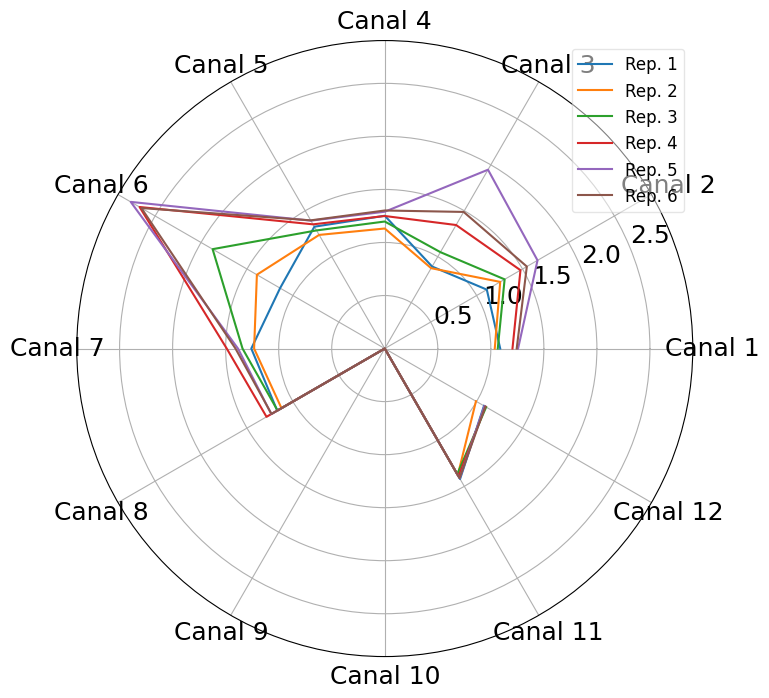

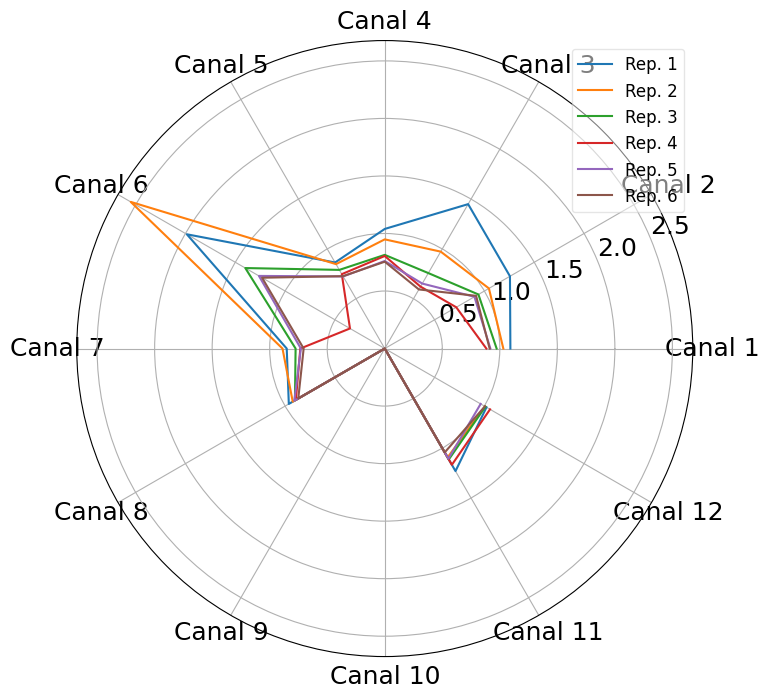

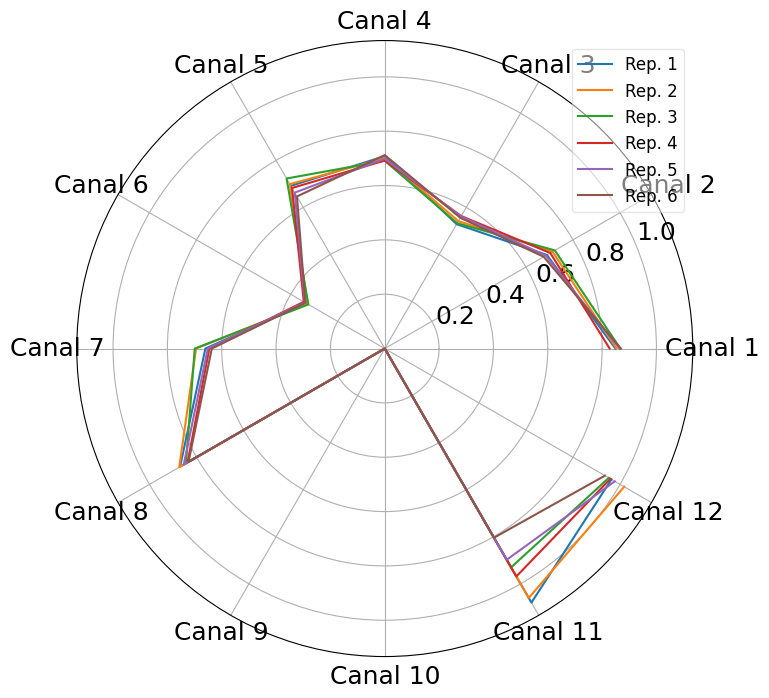

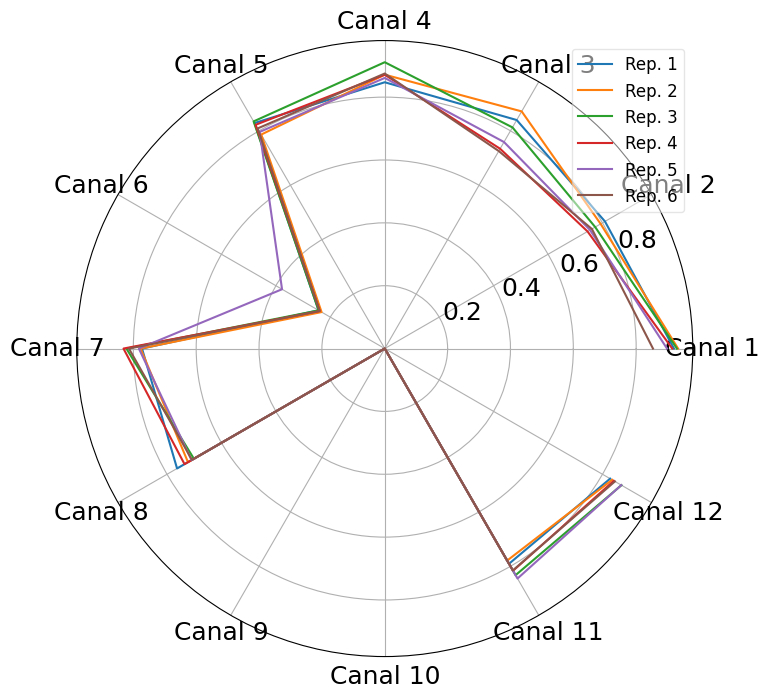

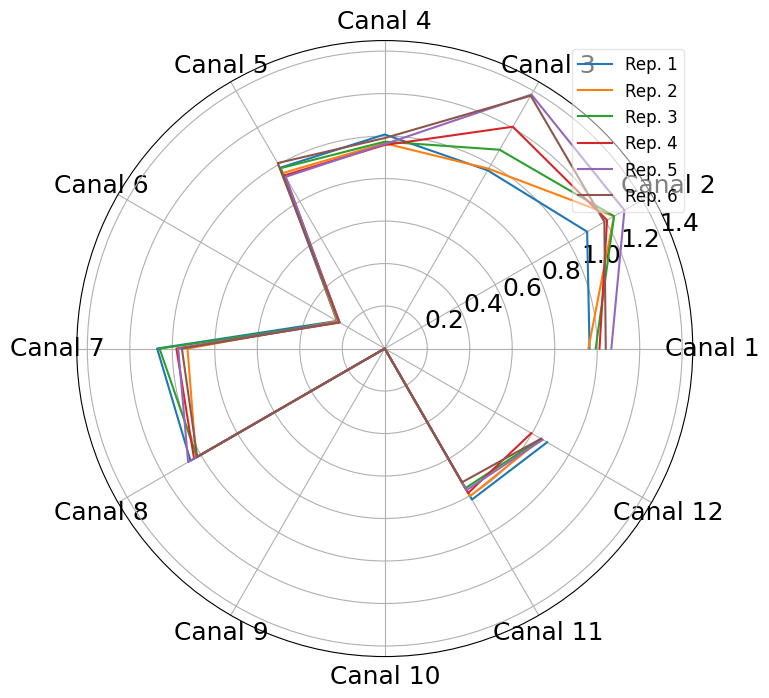

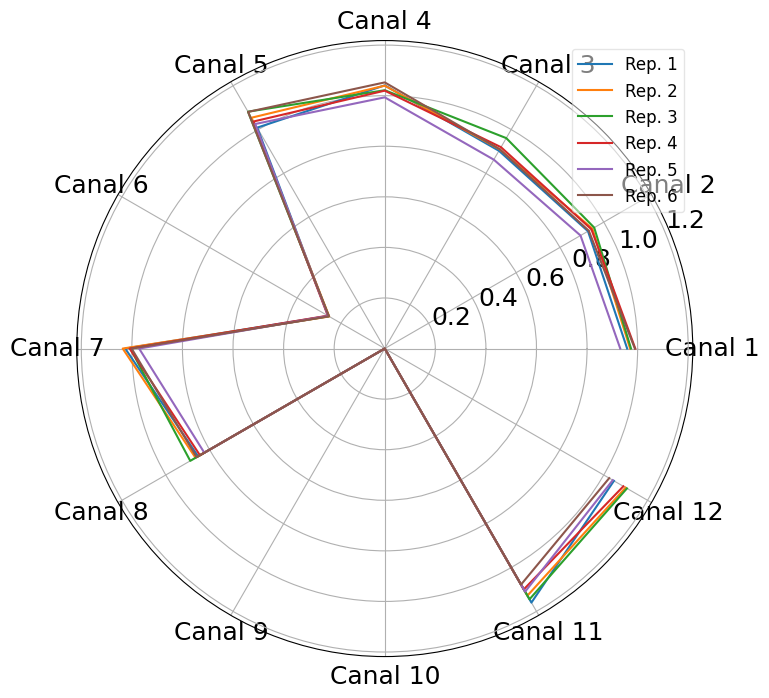

In [14]:
# elijo sujeto
j = 5

data_j = list_data_x_sujeto[j]
label_j = list_label_x_sujeto[j]

flancos = np.diff(label_j)  # Con estos flancos puedo dividir las repeticiones
rep_starts_ind = np.where(flancos>0)[0]
rep_ends_ind = np.where(flancos<0)[0]

etiqueta_repeticion = []
indices_repeticion = []

etiqueta_repeticion = label_j[rep_ends_ind]

# defino cantidad de gestos. esto en realidad podria sacarlo de etiqueta_repeticion directo
cant_gestos = 10

for i in range(1, cant_gestos + 1):
    ind_reps = np.where(etiqueta_repeticion == i)[0]
    # Crear un gráfico polar
    fig = plt.figure(figsize=(8, 8))  # Ajustar el tamaño de la figura para mejor proporción
    ax = fig.add_subplot(111, projection='polar')

    for idx, k in enumerate(ind_reps):
        sig = data_j[(rep_starts_ind[k] + 1): (rep_ends_ind[k] + 1)]
        std_x_canal = np.std(sig, axis=0)

        # Ángulos para cada canal
        theta = np.linspace(0, 2 * np.pi, len(std_x_canal), endpoint=False)

        # Graficar los datos
        ax.plot(theta, std_x_canal, label=f"Rep. {idx + 1}")

    # Especificar la cantidad de ticks manualmente para que coincida con la cantidad de etiquetas
    ax.set_xticks(theta)

    # Definir las etiquetas para los ticks
    labels = [f'Canal {j + 1}' for j in range(len(std_x_canal))]

    # Establecer las etiquetas de los ticks con tamaño 18
    ax.set_xticklabels(labels, fontsize=18)

    # Ajustar el tamaño de los números del eje radial (valores del eje polar)
    ax.tick_params(axis='y', labelsize=18)

    # Título con tamaño 18
    # ax.set_title(f"Gesto {i}", fontsize=18, fontweight='bold')

    # Añadir una leyenda con tamaño 18
    ax.legend(loc='upper right', fontsize=12, framealpha=0.5)

    # Guardar como PDF
    plt.savefig(f"Gesto_{i}_sujeto{j}.pdf", format="pdf", bbox_inches="tight")

    # Mostrar la imagen en pantalla
    plt.show()

    # Cerrar la figura para liberar memoria
    plt.close(fig)



In [15]:

for i in range(1, cant_gestos + 1):
    ind_reps = np.where(etiqueta_repeticion == i)[0]
    # Crear un gráfico polar
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')

    for idx, k in enumerate(ind_reps):
        sig = data_j[(rep_starts_ind[k] + 1): (rep_ends_ind[k] + 1)]
        std_x_canal = np.std(sig, axis=0)

        # Ángulos para cada canal
        theta = np.linspace(0, 2 * np.pi, len(std_x_canal), endpoint=False)

        # Graficar los datos
        ax.plot(theta, std_x_canal, label=f"Repetición {idx + 1}")

    # Especificar la cantidad de ticks manualmente para que coincida con la cantidad de etiquetas
    ax.set_xticks(theta)

    # Definir las etiquetas para los ticks
    labels = [f'Canal {j + 1}' for j in range(len(std_x_canal))]

    # Establecer las etiquetas de los ticks
    ax.set_xticklabels(labels, fontsize=28)

    # Título
    ax.set_title(f"Gesto {i}", fontsize=30, fontweight='bold')

    # Añadir una leyenda
    ax.legend(loc='upper right', fontsize=28)

    # Guardar como PDF
    plt.savefig(f"Gesto_{i}.pdf", format="pdf", bbox_inches="tight")

    # Cerrar la figura para liberar memoria
    plt.close(fig)

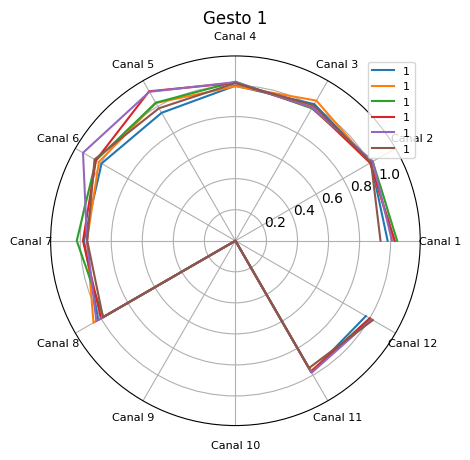

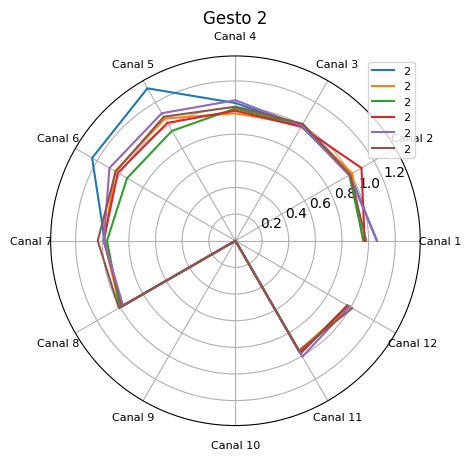

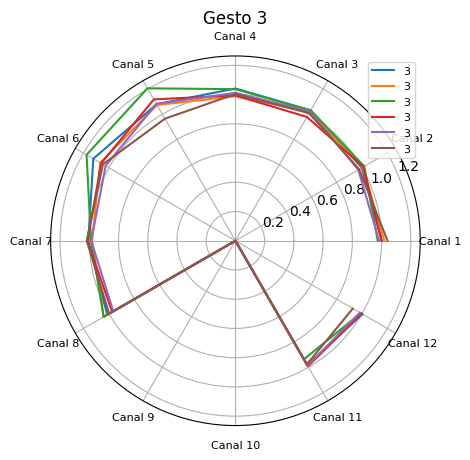

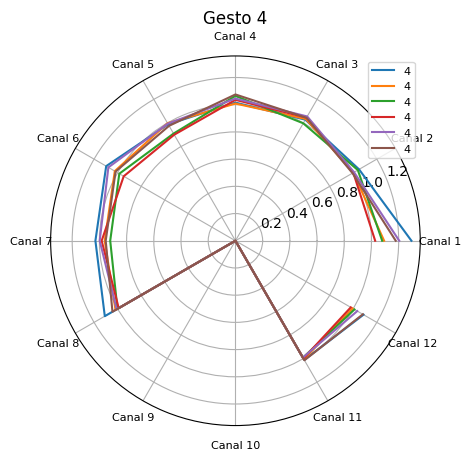

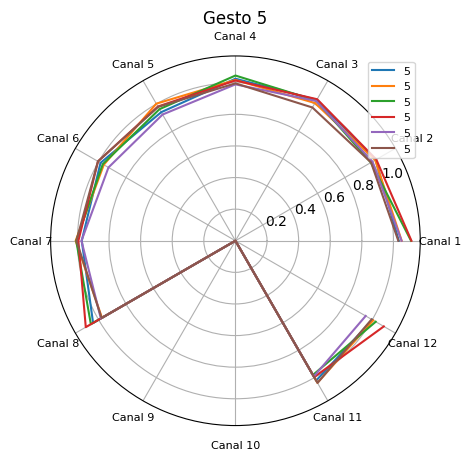

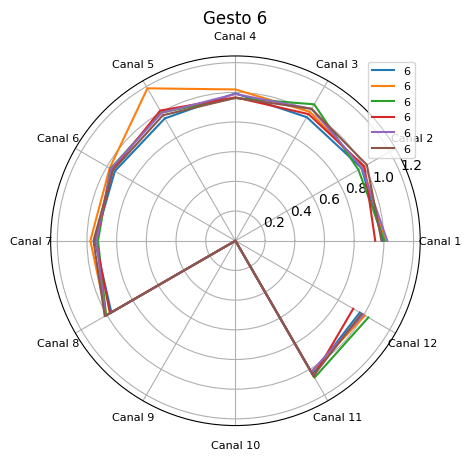

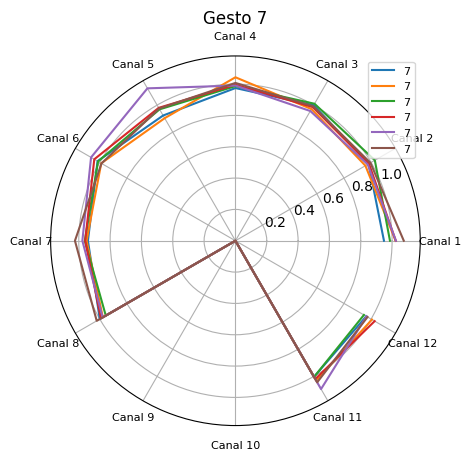

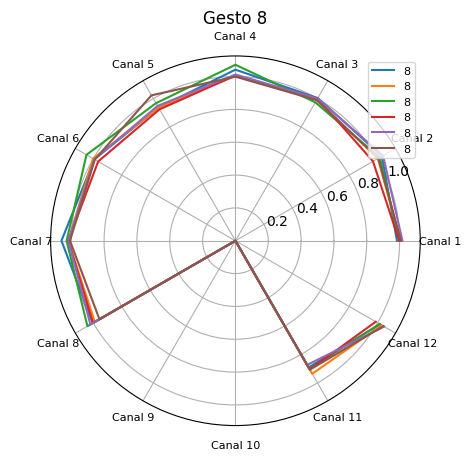

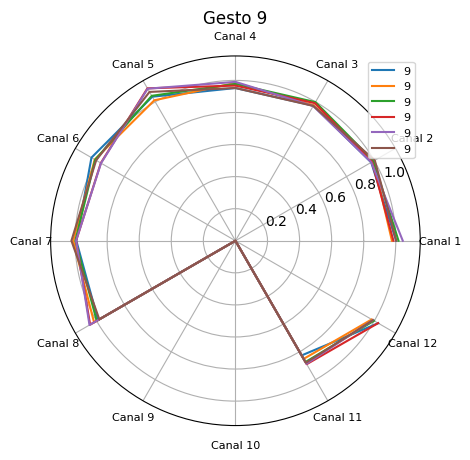

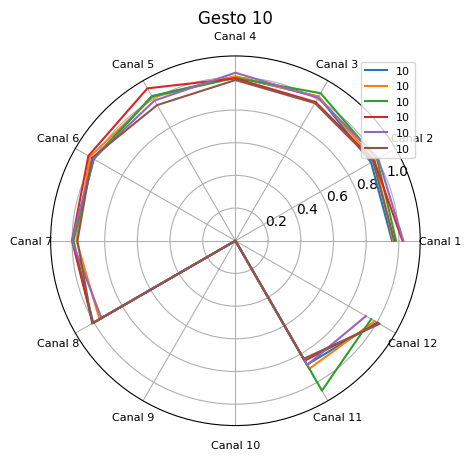

In [16]:
# elijo sujeto
j = 6

data_j = list_data_x_sujeto[j]
label_j = list_label_x_sujeto[j]

flancos = np.diff(label_j)  # Con estos flancos puedo dividir las repeticiones
rep_starts_ind = np.where(flancos>0)[0]
rep_ends_ind = np.where(flancos<0)[0]

etiqueta_repeticion = []
indices_repeticion = []

etiqueta_repeticion = label_j[rep_ends_ind]

# defino cantidad de gestos. esto en realidad podria sacarlo de etiqueta_repeticion directo
cant_gestos = 10

for i in range(1, cant_gestos+1):
  ind_reps = np.where(etiqueta_repeticion==i)[0]
  # Crear un gráfico polar
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='polar')

  for k in ind_reps:
    sig = data_j[(rep_starts_ind[k]+1): (rep_ends_ind[k]+1)]
    std_x_canal = np.std(sig, axis=0)

    # Ángulos para cada canal
    theta = np.linspace(0, 2*np.pi, len(std_x_canal), endpoint=False) # va a ser el mismo en todas las iteraciones

    # Graficar los datos
    ax.plot(theta, std_x_canal, label = str(i))

  # Especificar la cantidad de ticks manualmente para que coincida con la cantidad de etiquetas.
  ax.set_xticks(theta)
  # Definir las etiquetas para los ticks.
  labels = ['Canal 1', 'Canal 2', 'Canal 3', 'Canal 4', 'Canal 5', 'Canal 6', 'Canal 7', 'Canal 8', 'Canal 9', 'Canal 10', 'Canal 11', 'Canal 12']

  # Establecer las etiquetas de los ticks.
  ax.set_xticklabels(labels, fontsize=8)
  ax.set_title("Gesto "+str(i))

  # Añadir una leyenda
  ax.legend(loc='upper right', fontsize=8)

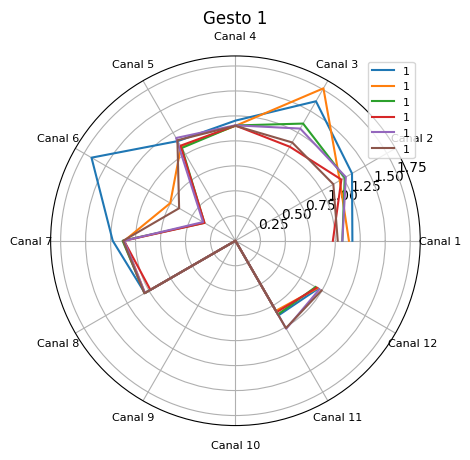

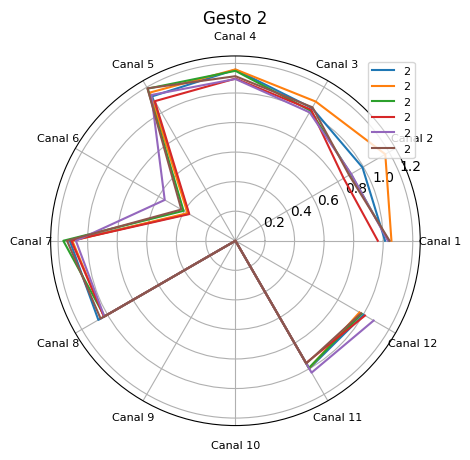

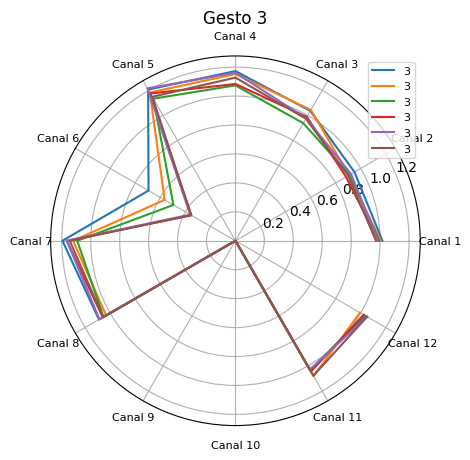

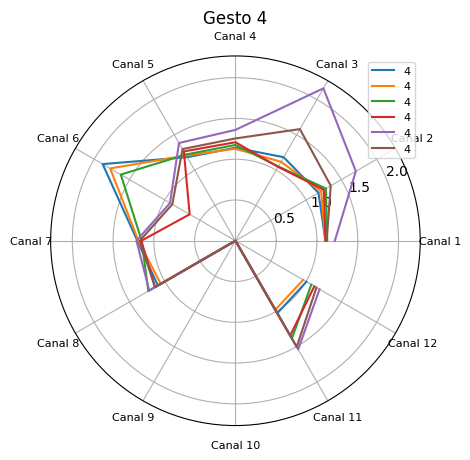

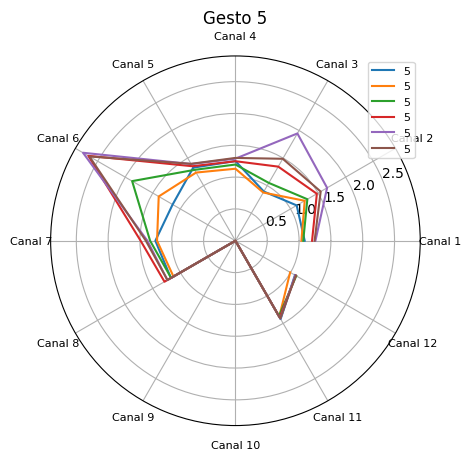

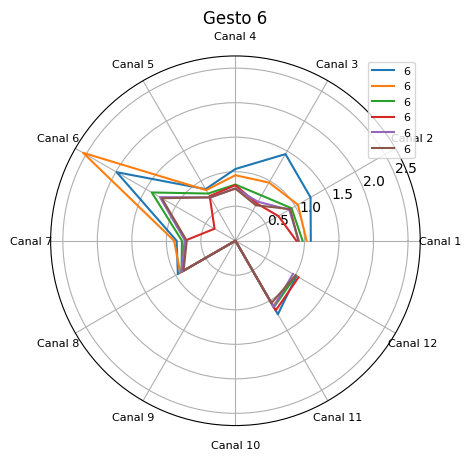

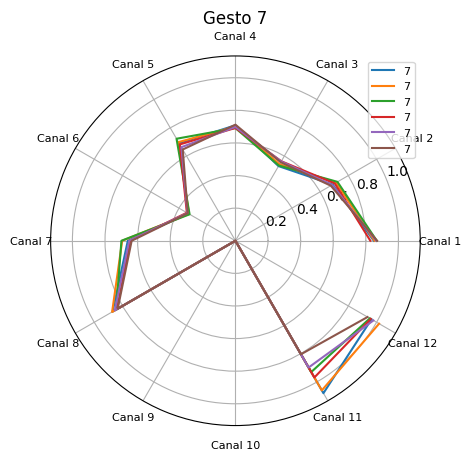

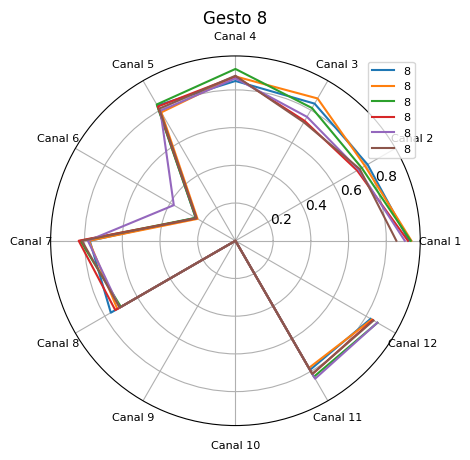

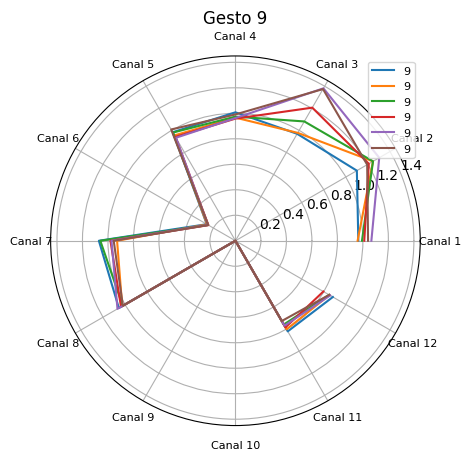

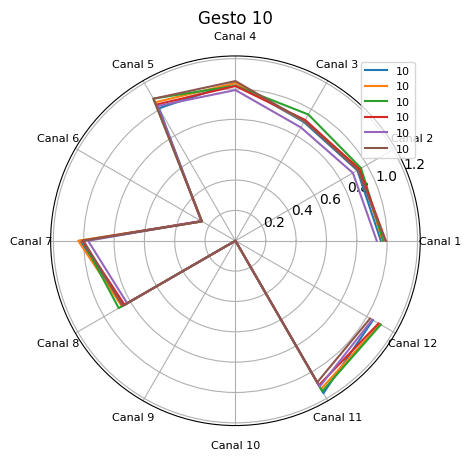

In [17]:
# elijo sujeto
j = 5

data_j = list_data_x_sujeto[j]
label_j = list_label_x_sujeto[j]

flancos = np.diff(label_j)  # Con estos flancos puedo dividir las repeticiones
rep_starts_ind = np.where(flancos>0)[0]
rep_ends_ind = np.where(flancos<0)[0]

etiqueta_repeticion = []
indices_repeticion = []

etiqueta_repeticion = label_j[rep_ends_ind]

# defino cantidad de gestos. esto en realidad podria sacarlo de etiqueta_repeticion directo
cant_gestos = 10

for i in range(1, cant_gestos+1):
  ind_reps = np.where(etiqueta_repeticion==i)[0]
  # Crear un gráfico polar
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='polar')

  for k in ind_reps:
    sig = data_j[(rep_starts_ind[k]+1): (rep_ends_ind[k]+1)]
    std_x_canal = np.std(sig, axis=0)

    # Ángulos para cada canal
    theta = np.linspace(0, 2*np.pi, len(std_x_canal), endpoint=False) # va a ser el mismo en todas las iteraciones

    # Graficar los datos
    ax.plot(theta, std_x_canal, label = str(i))

  # Especificar la cantidad de ticks manualmente para que coincida con la cantidad de etiquetas.
  ax.set_xticks(theta)
  # Definir las etiquetas para los ticks.
  labels = ['Canal 1', 'Canal 2', 'Canal 3', 'Canal 4', 'Canal 5', 'Canal 6', 'Canal 7', 'Canal 8', 'Canal 9', 'Canal 10', 'Canal 11', 'Canal 12']

  # Establecer las etiquetas de los ticks.
  ax.set_xticklabels(labels, fontsize=8)
  ax.set_title("Gesto "+str(i))

  # Añadir una leyenda
  ax.legend(loc='upper right', fontsize=8)